In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Make sure this import is after pandas
import Backend.NXCALS as nx

# Importing data
database = pd.read_parquet('Data_merged/dataset_2022_05_22.parquet')
database.insert(0,'Time',(database.index - database.index[0]).total_seconds())

MDWindow = [pd.Timestamp('2022-05-22 13:30'),pd.Timestamp('2022-05-22 16:45')]
MDTime = (MDWindow[1]-MDWindow[0]).total_seconds()

#locations = ['L1B1','R1B2','L5B1','R5B2']
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
lineInfo  = [('b','-v'),('r','-v'),('b','-^'),('r','-^')]




### Tune VS Current

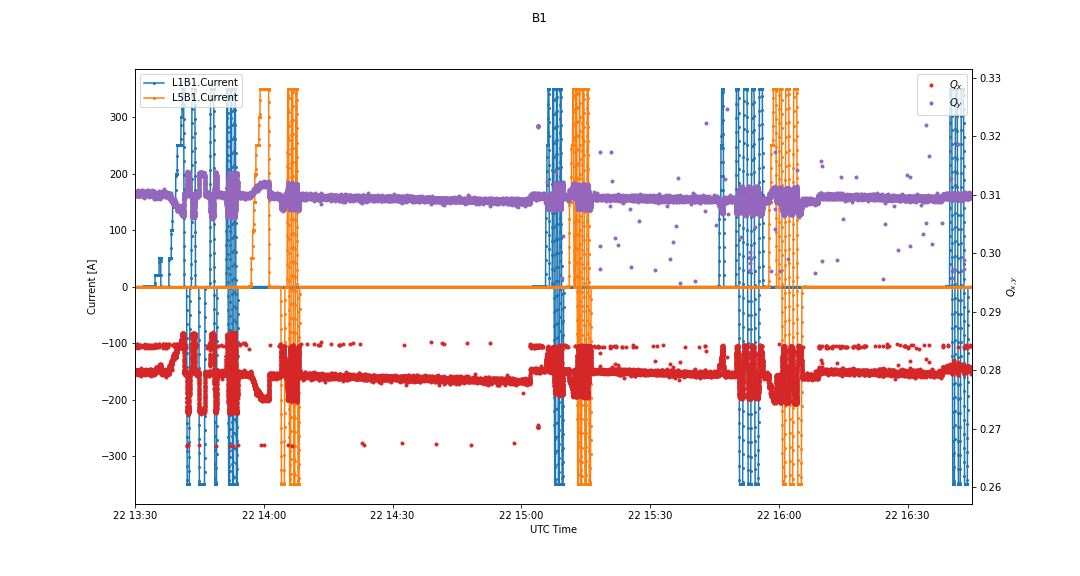

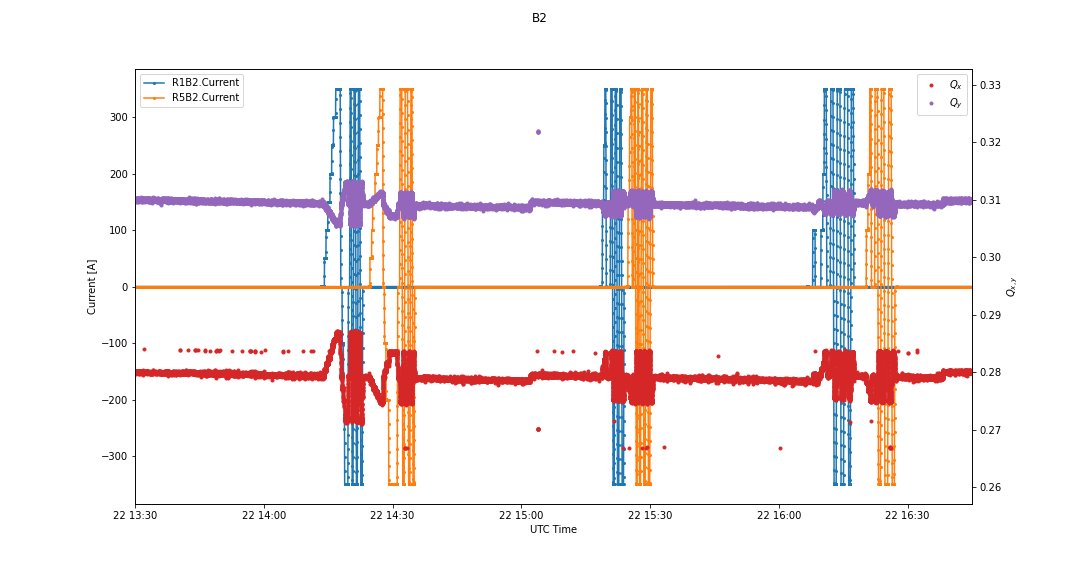

In [6]:

#%matplotlib inline
%matplotlib widget

for beam in beams:
    
    plt.figure(figsize=(15, 8))
    plt.suptitle(beam.name)
    
    
    for wire,color in zip(wires[beam.name],['C0','C1']):
        database.nxPlot('index',wire['I'],'-o',ms=2,label = wire.loc + '.' + wire.label['I'])
        
    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
        
    ax2 = plt.gca().twinx()
    plt.sca(ax2)
    database.nxPlot('index',beam['Qx_HS'],'.',color='C3',label = beam.label['Qx_HS'])
    database.nxPlot('index',beam['Qy_HS'],'.',color='C4',label = beam.label['Qy_HS'])
    

    plt.legend(loc='upper right')
    plt.ylabel(r'$Q_{x,y}$')
    plt.xlim(MDWindow)
    
    


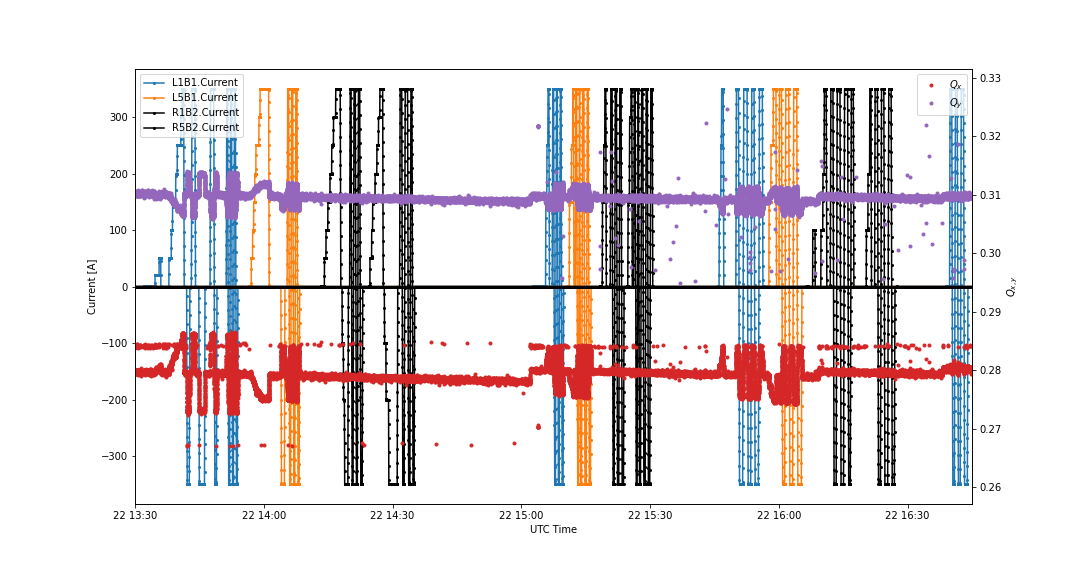

In [5]:

#%matplotlib inline
%matplotlib widget


plt.figure(figsize=(15, 8))

ax1 = plt.gca()
ax2 = plt.gca().twinx()
    
for beam in beams:
    
    
    plt.sca(ax1)
    
    for wire,color in zip(wires[beam.name],['C0','C1']):
        if beam.name == 'B2':
            color = 'k'
        database.nxPlot('index',wire['I'],'-o',color=color,ms=2,label = wire.loc + '.' + wire.label['I'])
        
    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
        

    plt.sca(ax2)
    if beam.name == 'B2':
        pass
    else:
        database.nxPlot('index',beam['Qx_HS'],'.',color='C3',label = beam.label['Qx_HS'])
        database.nxPlot('index',beam['Qy_HS'],'.',color='C4',label = beam.label['Qy_HS'])
    

    plt.legend(loc='upper right')
    plt.ylabel(r'$Q_{x,y}$')
    plt.xlim(MDWindow)
    
    


### Reconstructing Tune shift

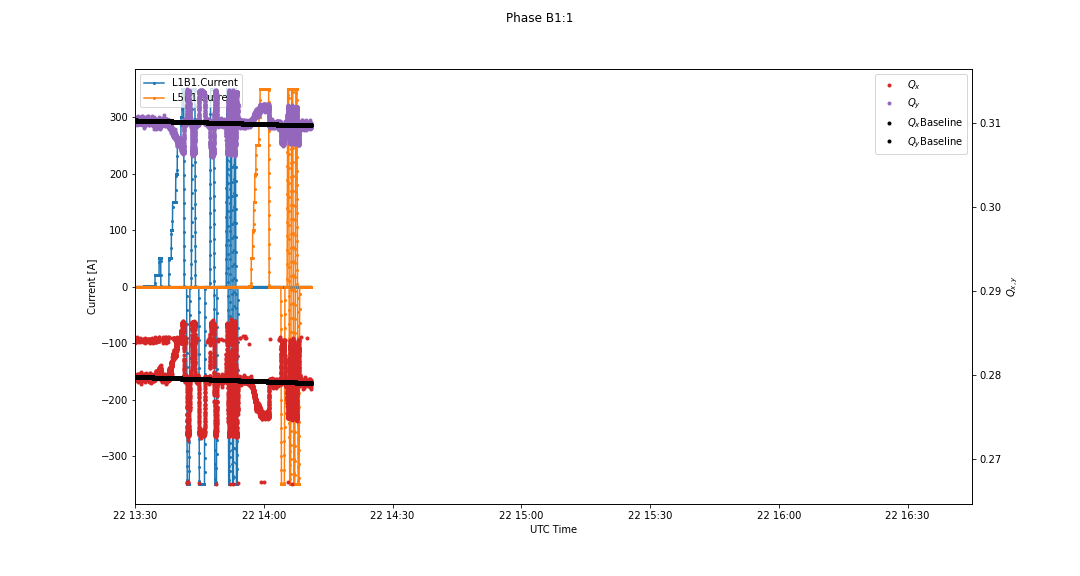

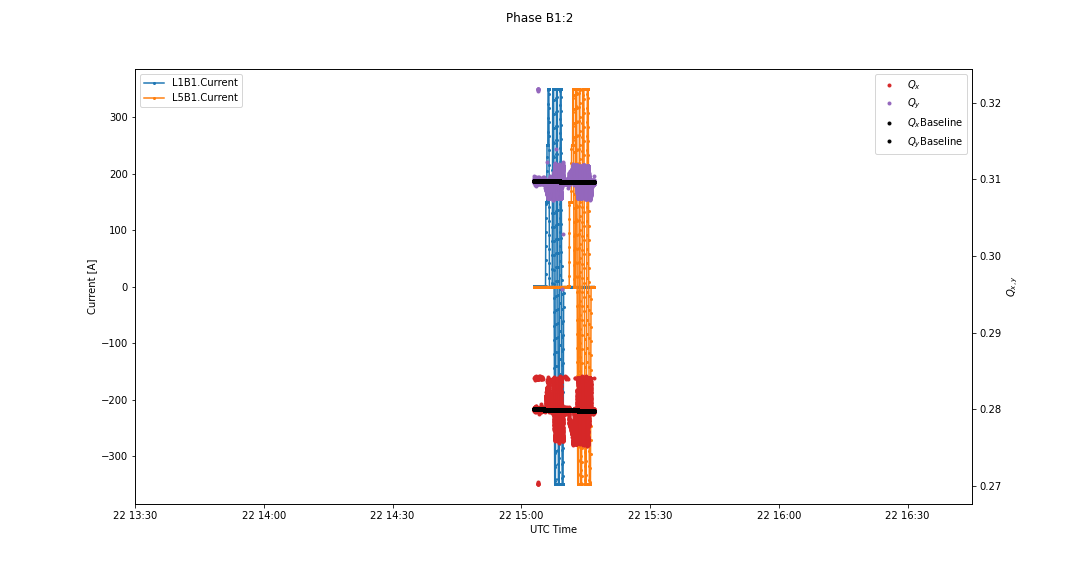

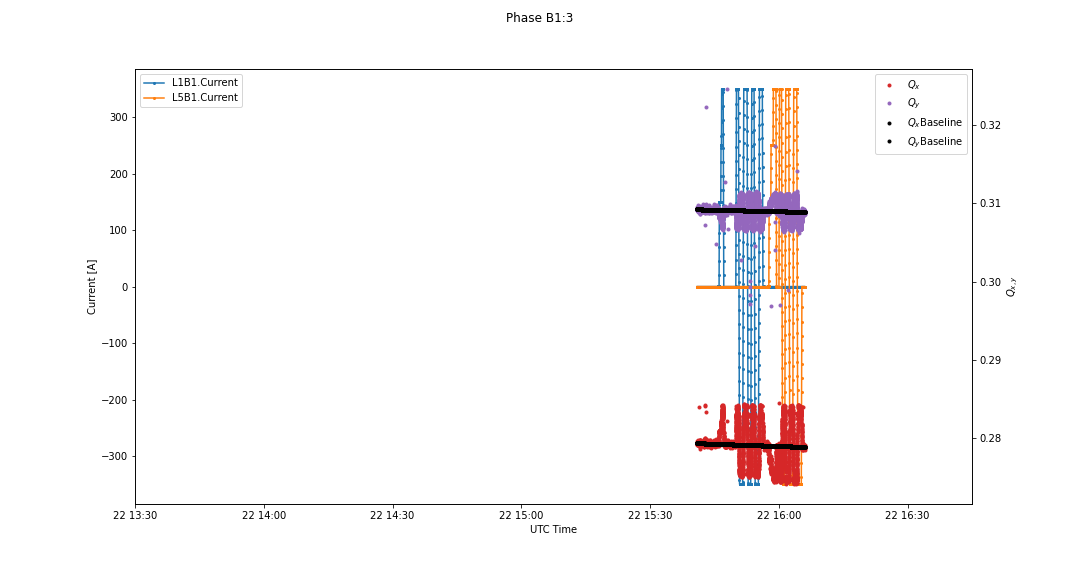

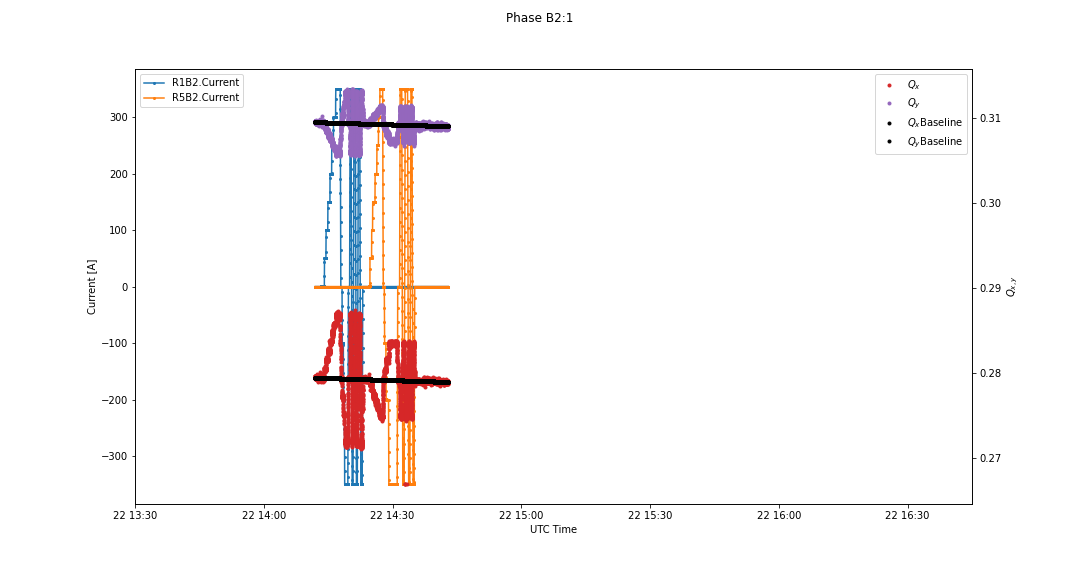

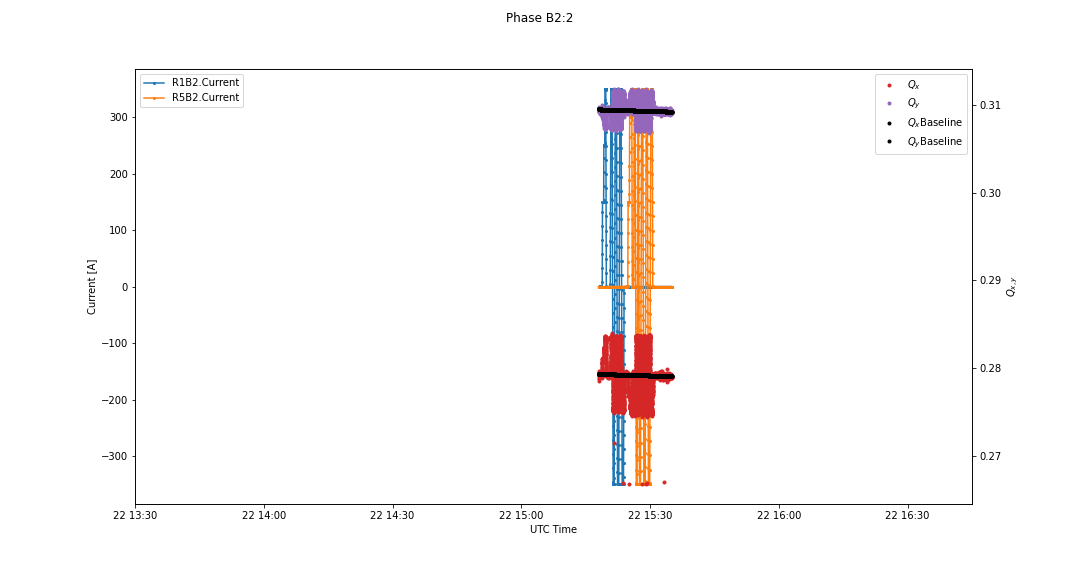

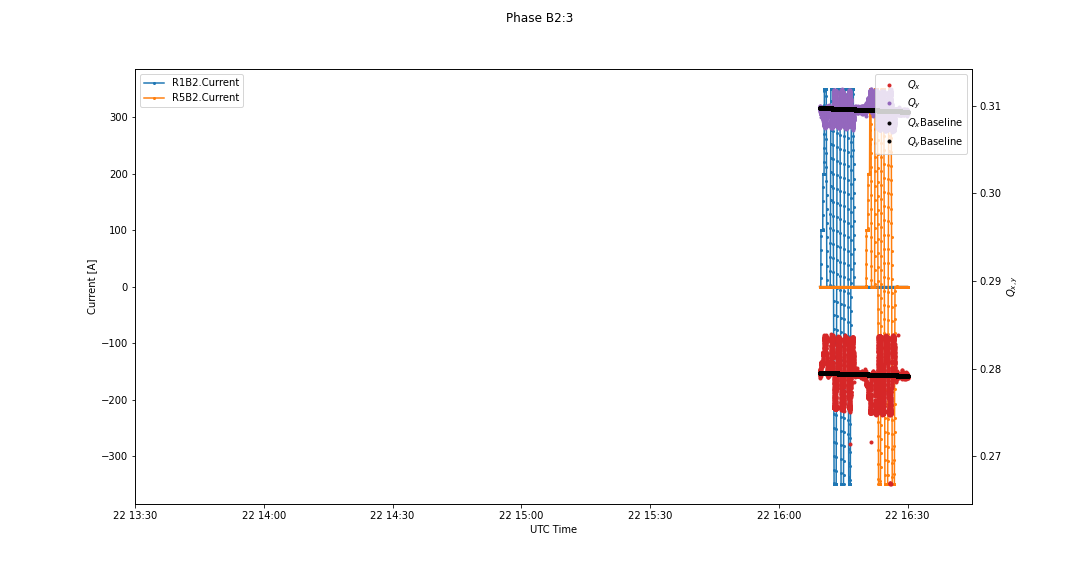

In [20]:

# Grouping data into ON-current phases for both B1 and B2
#=========================================================
phase_list= {'B1:1': [pd.Timestamp('2022-05-22 13:30')   ,pd.Timestamp('2022-05-22 14:11')],
             'B1:2': [pd.Timestamp('2022-05-22 15:03')   ,pd.Timestamp('2022-05-22 15:17')],
             'B1:3': [pd.Timestamp('2022-05-22 15:41')   ,pd.Timestamp('2022-05-22 16:06')],
             'B2:1': [pd.Timestamp('2022-05-22 14:12')   ,pd.Timestamp('2022-05-22 14:43')],
             'B2:2': [pd.Timestamp('2022-05-22 15:18')   ,pd.Timestamp('2022-05-22 15:35')],
             'B2:3': [pd.Timestamp('2022-05-22 16:09:30'),pd.Timestamp('2022-05-22 16:30')]
            }

if 'Phase' not in database.columns:
    database.insert(1,'Phase','None')
    for name,_window in phase_list.items():
        cutting = pd.cut(database.index,bins=_window)

        database.loc[list(database.groupby(cutting).get_group(cutting.categories[0]).index),'Phase']  = name
#==========================================================



grouped = database.groupby('Phase')

for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]

    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']

    # Finding location of ON/OFF current
    ON_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                    group.dropna(subset=[wire1['I']])[wire1['I']])

    ON_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                    group.dropna(subset=[wire2['I']])[wire2['I']])

    # Setting values to 0 or 1
    ON_wire1[np.abs(ON_wire1)<0.1] = 0
    ON_wire2[np.abs(ON_wire2)<0.1] = 0
    #-----
    ON_wire1[np.abs(ON_wire1)>0.1] = 1
    ON_wire2[np.abs(ON_wire2)>0.1] = 1


    # Keeping only values when both are off
    ON_baseline = np.invert(ON_wire1.astype(bool))*np.invert(ON_wire2.astype(bool))



    def baseline(t,a,b):
        return a*t+b


    t  = tuneTimes[ON_baseline]
    for tune in [beam['Qy_HS'],beam['Qx_HS']]:
        if tune+'_baseline' not in database.columns:
            database.insert(2,tune+'_baseline',np.nan)
            database.insert(3,tune+'_shift',np.nan)

        Q = subset[tune][ON_baseline]

        cutoff = 4*np.std(Q)
        outliers = np.abs(Q-np.mean(Q))>cutoff

        popt, pcov = curve_fit(baseline, t[~outliers],Q[~outliers])

        database.loc[tuneIndex,tune+'_baseline'] = baseline(tuneTimes,*popt)
        database.loc[tuneIndex,tune+'_shift']    = subset[tune] - baseline(tuneTimes,*popt)

        
        
grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam 
    beam = [beam for beam in beams if beam.name in name][0] 
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Phase ' + name)
    # Plot current in wire
    for wire,color in zip(wires[beam.name],['C0','C1']):
        
        group.nxPlot('index',wire['I'],'-o',color=color,ms=2,label = wire.loc + '.' + wire.label['I'])

    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")


    ax2 = plt.gca().twinx()
    plt.sca(ax2)

    group.nxPlot('index',beam['Qx_HS'],'.',color='C3',label = beam.label['Qx_HS'])
    group.nxPlot('index',beam['Qy_HS'],'.',color='C4',label = beam.label['Qy_HS'])

    group.nxPlot('index',beam['Qx_HS']+'_baseline','.',color='k',label = beam.label['Qx_HS']+'Baseline')
    group.nxPlot('index',beam['Qy_HS']+'_baseline','.',color='k',label = beam.label['Qy_HS']+'Baseline')


    plt.legend(loc='upper right')
    plt.ylabel(r'$Q_{x,y}$')
    plt.xlim(MDWindow)


# Plotting tune shift

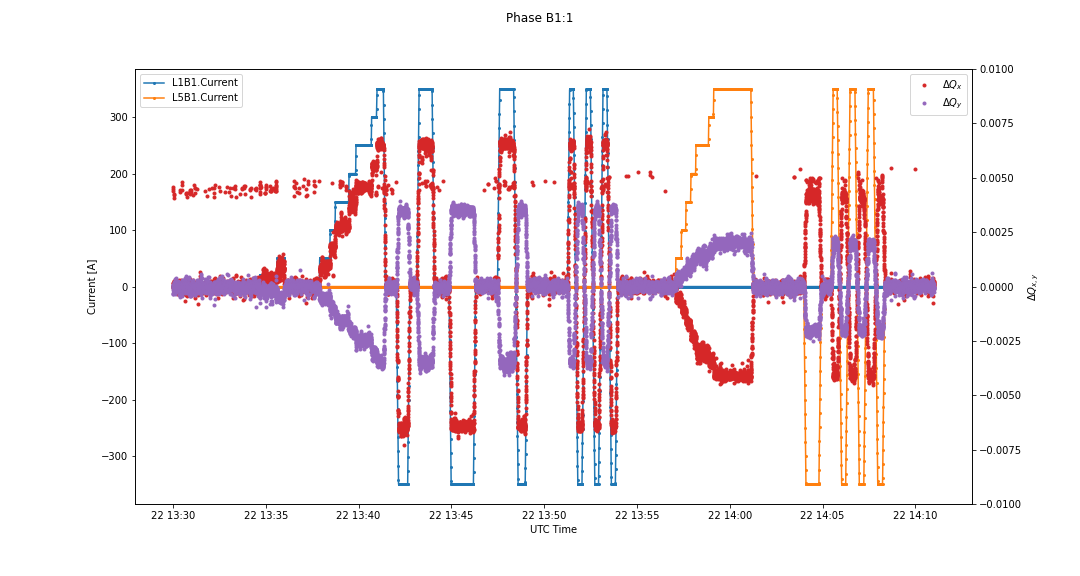

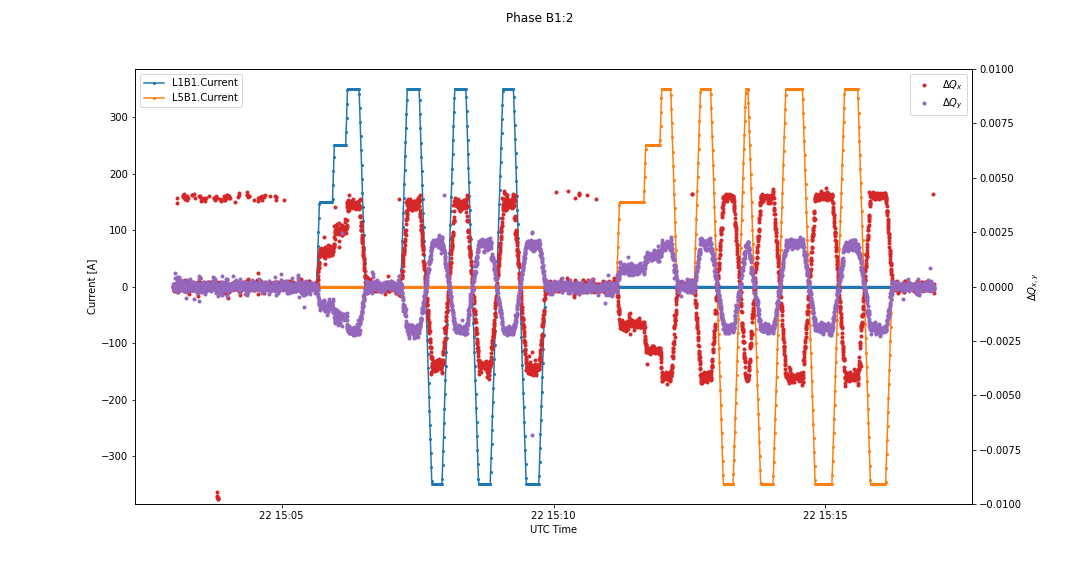

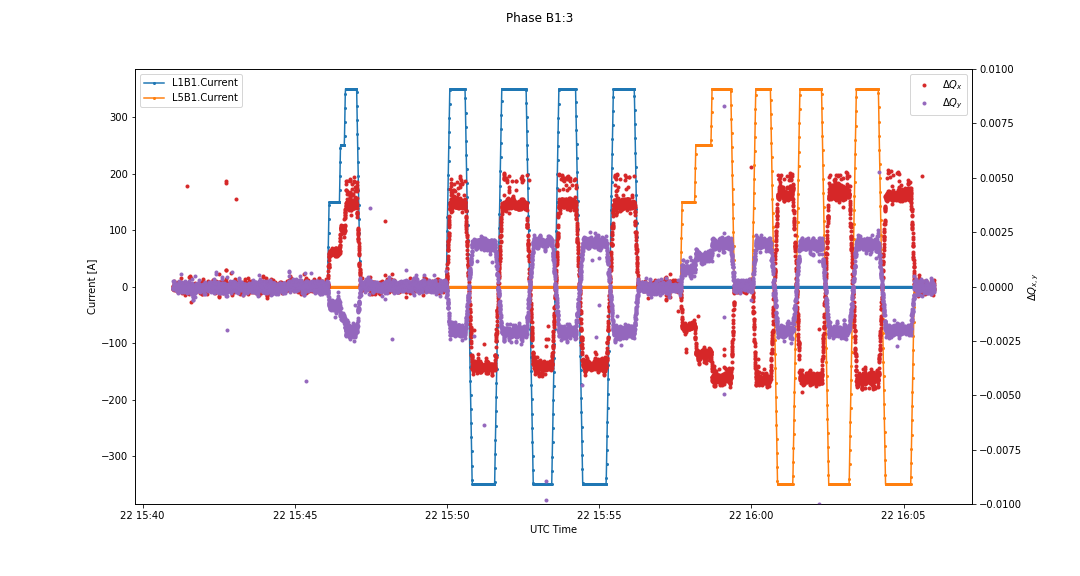

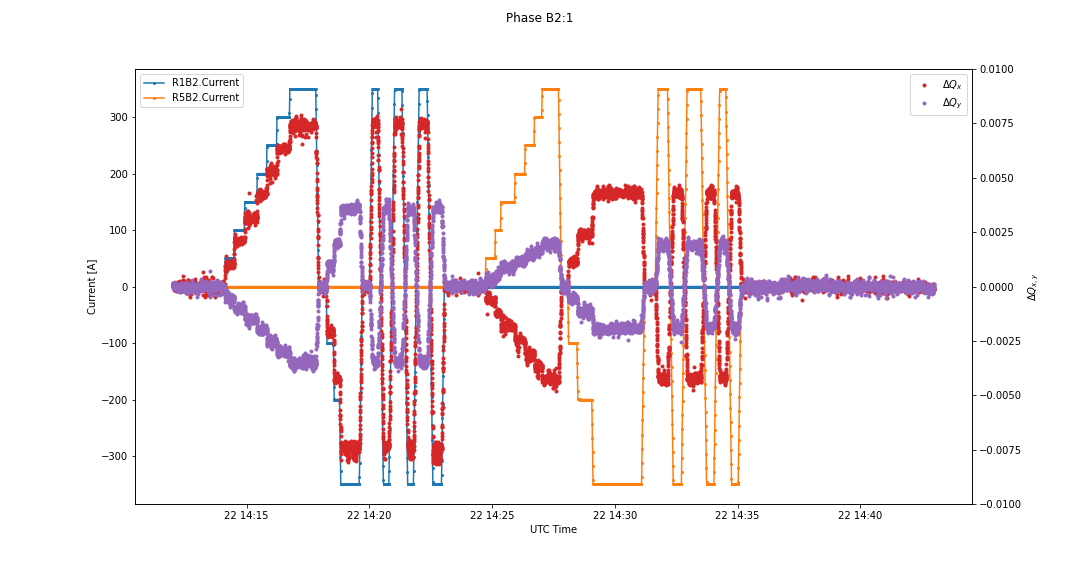

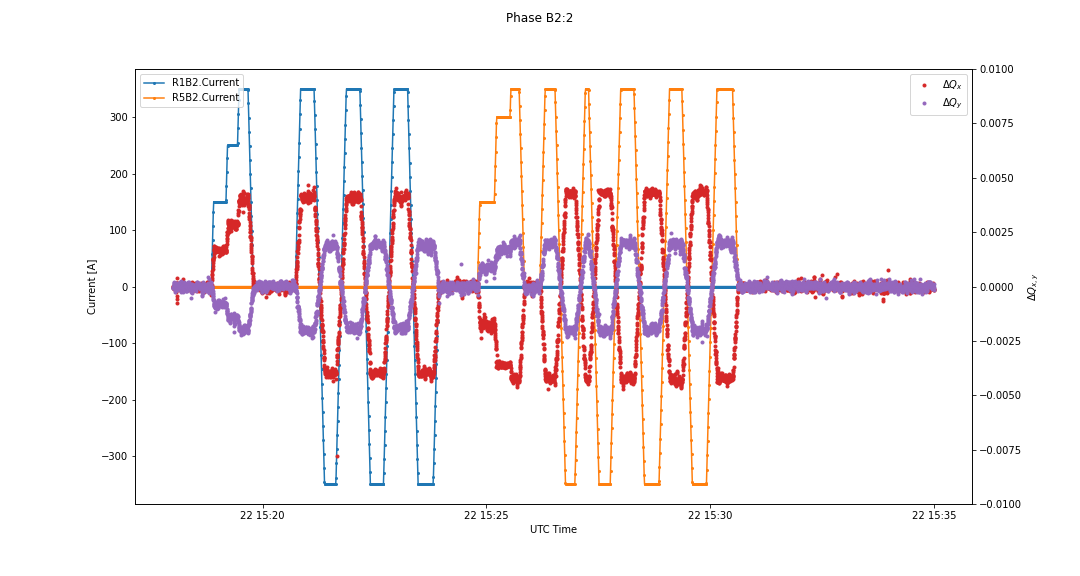

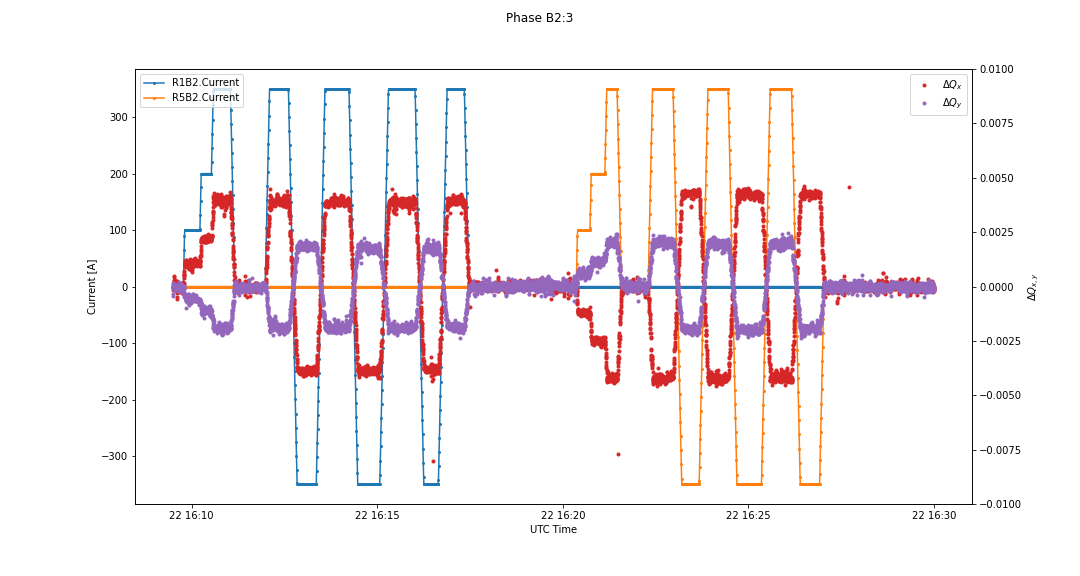

In [8]:
%matplotlib widget

grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam 
    beam = [beam for beam in beams if beam.name in name][0]  
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Phase ' + name)
    # Plot current in wire
    for wire,color in zip(wires[beam.name],['C0','C1']):
        group.nxPlot('index',wire['I'],'-o',color=color,ms=2,label = wire.loc + '.' + wire.label['I'])

    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")


    ax2 = plt.gca().twinx()
    plt.sca(ax2)


    group.nxPlot('index',beam['Qx_HS']+'_shift','.',color='C3',label = r'$\Delta$'+beam.label['Qx_HS'])
    group.nxPlot('index',beam['Qy_HS']+'_shift','.',color='C4',label = r'$\Delta$'+beam.label['Qy_HS'])
    plt.ylim([-0.01,0.01])

    plt.legend(loc='upper right')
    plt.ylabel(r'$\Delta Q_{x,y}$')
    #plt.xlim(MDWindow)
    
    

# Tune Shift vs current

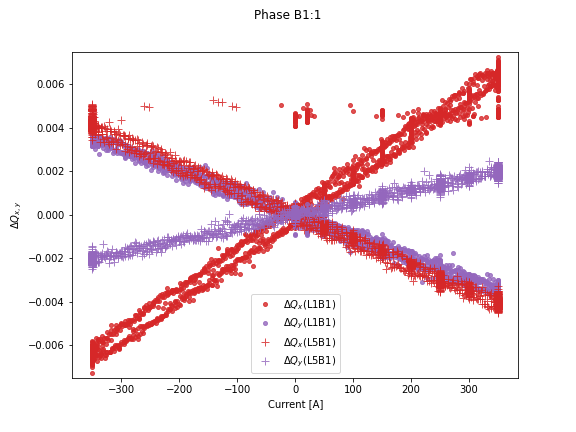

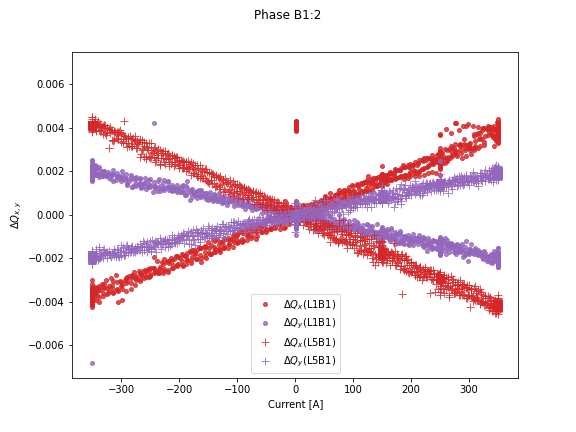

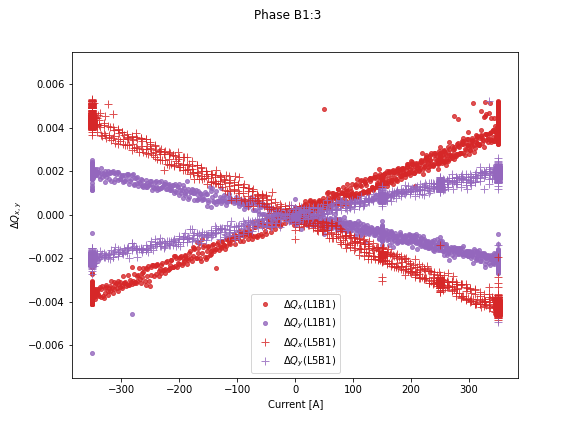

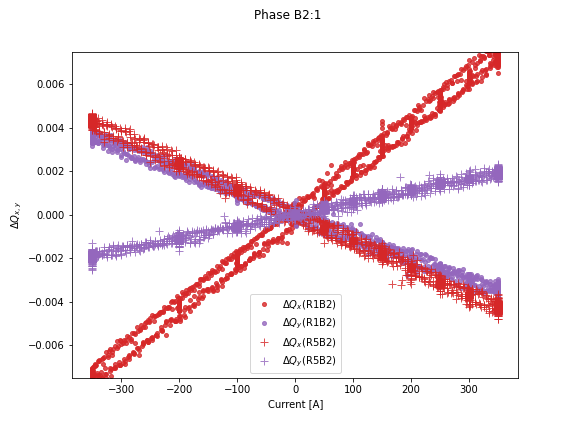

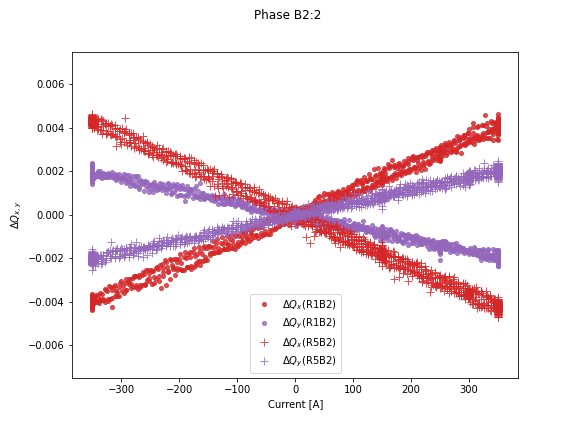

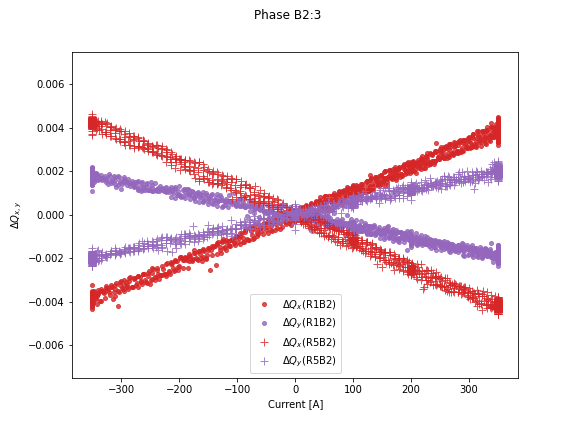

In [24]:


    
    
%matplotlib widget

grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(8, 6))
    plt.suptitle('Phase ' + name)
    
    plt.plot(I_wire1[on_wire1],DQx[on_wire1],'.',ms=8,alpha=0.8,color='C3',label=r'$\Delta Q_x$' + f'({wire1.loc})')
    plt.plot(I_wire1[on_wire1],DQy[on_wire1],'.',ms=8,alpha=0.8,color='C4',label=r'$\Delta Q_y$' + f'({wire1.loc})')
    
    plt.plot(I_wire2[on_wire2],DQx[on_wire2],'+',ms=8,alpha=0.8,color='C3',label=r'$\Delta Q_x$' + f'({wire2.loc})')
    plt.plot(I_wire2[on_wire2],DQy[on_wire2],'+',ms=8,alpha=0.8,color='C4',label=r'$\Delta Q_y$' + f'({wire2.loc})')
    
    plt.legend()
    
    plt.ylim([-0.0075,0.0075])
    
    plt.ylabel(r'$\Delta Q_{x,y}$')
    plt.xlabel(f"{wire.label['I']} [{wire.units['I']}]")
    
    